### View and work with LED calibration files 

Ran from midway3 with

./start_jupyter.sh --ram 122880 --partition caslake

I guess take mean of triggered? 

Could also pull data for multiple weeks and check how much it changes over time

In [2]:
os.listdir('/project2/lgrandi/led_calibration/PMTCalXe/software/')

NameError: name 'os' is not defined

In [39]:
with open('/project2/lgrandi/led_calibration/PMTCalXe/software/LEDanalysis.py', 'r') as f:
    print(f.read())

import numpy as np
import pandas as pd
import scipy as sp
from scipy.signal import savgol_filter

import configparser as cp

import tqdm
import time
import datetime
import warnings

#from utilix.rundb import pymongo_collection
from utilix import xent_collection
import re

print('\n\n\n')
print('___   ___  _______ .__   __.   ______   .__   __.        .___________.   __  __             _____    _____    ____   ')
print('\  \ /  / |   ____||  \ |  |  /  __  \  |  \ |  |        |           |  |  \/  |    /\     / ____|  |_   _| /  ___|  ')
print(' \  V  /  |  |__   |   \|  | |  |  |  | |   \|  |  _   _ `---|  |----`  | \  / |   /  \    | |  __    | |   | |      ')
print('  >   <   |   __|  |  . `  | |  |  |  | |  . `  | | \ | |    |  |       | |\/| |  / /\ \   | | |_ |   | |   | |      ')
print(' /  .  \  |  |____ |  |\   | |  `--`  | |  |\   | |  \| |    |  |       | |  | | / ____ \  | |__| |  _| |_  | |___   ')
print('/__/ \__\ |_______||__| \__|  \______/  |__| \__| |_|\__|    |__|    

In [1]:
# basic imports and path to calibration software 
import sys
import os
sys.path.append('/project2/lgrandi/led_calibration/PMTCalXe/software/')
from for_plotting import *
from LEDanalysis  import *
PMT = PMTanalyzer(path_to_config = '/project2/lgrandi/led_calibration/PMTCalXe/configurations/configuration_analysis_SR2_2024_January.ini', 
                  date = '20240814')

import matplotlib.pyplot as plt
Config = cp.ConfigParser()
Config.read(PMT.config_file)





___   ___  _______ .__   __.   ______   .__   __.        .___________.   __  __             _____    _____    ____   
\  \ /  / |   ____||  \ |  |  /  __  \  |  \ |  |        |           |  |  \/  |    /\     / ____|  |_   _| /  ___|  
 \  V  /  |  |__   |   \|  | |  |  |  | |   \|  |  _   _ `---|  |----`  | \  / |   /  \    | |  __    | |   | |      
  >   <   |   __|  |  . `  | |  |  |  | |  . `  | | \ | |    |  |       | |\/| |  / /\ \   | | |_ |   | |   | |      
 /  .  \  |  |____ |  |\   | |  `--`  | |  |\   | |  \| |    |  |       | |  | | / ____ \  | |__| |  _| |_  | |___   
/__/ \__\ |_______||__| \__|  \______/  |__| \__| |_|\__|    |__|       |_|  |_|/_/    \_\ \ _____| |_____| \_____|  
powered by Giovanni Volta, Chiara Capelli, Shingo Kazama and Mariana Rajado (c)




(runs == None)and(self.runs_from_db)and(date != None)


['/project2/lgrandi/led_calibration/PMTCalXe/configurations/configuration_analysis_SR2_2024_January.ini']

In [2]:
# you can work in the latest anaylsis envrionment for SR2, for RCC (check here : https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenonnt:analysis:environments)
import strax, straxen
straxen.print_versions()

/project2/lgrandi/xenonnt/software/cutax/v1.19.5/cutax/cut_lists/science.py:28: UserWarning: Removing cut <class 'cutax.cuts.s2_width.S2Width'>
  warnings.warn(f"Removing cut {cut}", UserWarning)
/project2/lgrandi/xenonnt/software/cutax/v1.19.5/cutax/cut_lists/science.py:28: UserWarning: Removing cut <class 'cutax.cuts.s2_width.S2Width'>
  warnings.warn(f"Removing cut {cut}", UserWarning)


,module,version,path,git
0,python,3.9.21,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
1,strax,1.6.5,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
2,straxen,2.2.7,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
3,cutax,1.19.5,/project2/lgrandi/xenonnt/software/cutax/v1.19...,None


In [3]:
# loading straxen LED context and appeding the data directory with the strax data 
st = straxen.contexts.xenonnt_led(_rucio_local_path='/project/lgrandi/rucio', include_rucio_local = True)
st.storage.append(strax.DataDirectory(PMT.straxdata, readonly=True))
st.storage.append(strax.DataDirectory('/project2/lgrandi/led_calibration/strax_data', readonly=True)) 

You specified _auto_append_rucio_local=True and you are not on dali compute nodes, so we will add the following rucio local path: /project/lgrandi/rucio/


In [6]:
# define your pmt, run_id and time range
# TODO Add PMT alive

pmt = 253  
run_id = "069375" # check in the run DB and configuration file if this run is valid for your PMT channel 

seconds_range = (0, 120)  # should be enough to get all the data

# load the data 
led_data = st.get_array(run_id, 'led_calibration', selection=f'(channel=={pmt})', seconds_range=seconds_range)


Loading led_calibration: |          | 0.00 % [00:00<?]

In [30]:
"""


        area: Area under the LED pulse, averaged over multiple integration windows.

        area_noise: Area in a noise window far from the LED signal.

        amplitude_led: Peak amplitude of the LED signal.

        amplitude_noise: Peak amplitude in a noise window.

        channel: PMT channel identifier.

        time: Start time of the interval (ns since UNIX epoch).

        dt: Time resolution in nanoseconds.

        length: Length of the interval in samples.

        triggered: Boolean indicating if a hit was found in the record.

        hit_position: Sample index of the hit defining the window position.

        integration_window: Integration window used for area calculations.

        baseline: Baseline of the record.



"""

'\n\n\n        area: Area under the LED pulse, averaged over multiple integration windows.\n\n        area_noise: Area in a noise window far from the LED signal.\n\n        amplitude_led: Peak amplitude of the LED signal.\n\n        amplitude_noise: Peak amplitude in a noise window.\n\n        channel: PMT channel identifier.\n\n        time: Start time of the interval (ns since UNIX epoch).\n\n        dt: Time resolution in nanoseconds.\n\n        length: Length of the interval in samples.\n\n        triggered: Boolean indicating if a hit was found in the record.\n\n        hit_position: Sample index of the hit defining the window position.\n\n        integration_window: Integration window used for area calculations.\n\n        baseline: Baseline of the record.\n\n\n\n'

In [8]:
# you can see the fields saved in the data - the one you are interested in is 'amplitude_led', but feel free to explore 
print(led_data.dtype.names)

('area', 'amplitude_led', 'amplitude_noise', 'channel', 'time', 'dt', 'length')


In [7]:
led_data['baseline']

array([15993.25 , 15993.85 , 15993.575, ..., 15994.925, 15994.375,
       15994.85 ], dtype=float32)

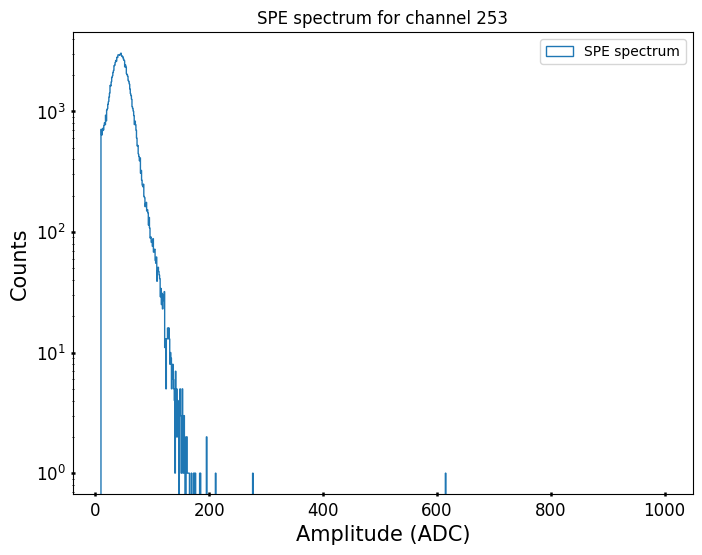

In [9]:
import matplotlib.pyplot as plt

# extract the amplitude data
amplitudes = led_data['amplitude_led']#[led_data['triggered']]

# plot a histogram of the SPE spectrum
plt.figure(figsize=(8, 6))
plt.hist(amplitudes, bins=1000, range=(10, 1000), histtype='step', label='SPE spectrum')
plt.xlabel('Amplitude (ADC)')
plt.ylabel('Counts')
plt.title(f'SPE spectrum for channel {pmt}')
plt.yscale('log')  
plt.legend()
plt.show()

Mean = 43.47746785655403
Std = 16.36743226827779 ADC
45.62221 17.958982
44.81728 9.397088


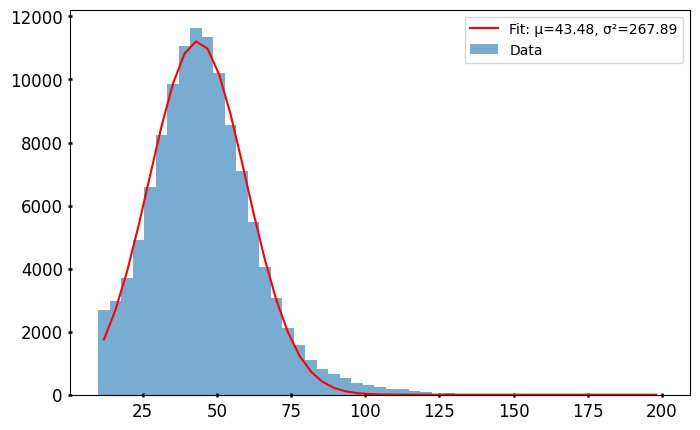

In [10]:
# Histogram
from scipy.optimize import curve_fit
bins =np.linspace(10,200)
counts, bin_edges = np.histogram(amplitudes, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Fit the Gaussian
popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), np.mean(amplitudes), np.std(amplitudes)])

A, mu, sigma = popt
variance = sigma**2

print(f"Mean = {mu}")
print(f"Std = {sigma} ADC")

tmp = led_data['amplitude_led']#[led_data['triggered']]
tmp = tmp[(tmp > 10) & (tmp < 150)]

print(tmp.mean(), tmp.std())
print(tmp[(tmp > (tmp.mean()- tmp.std())) & (tmp < (tmp.mean()+ tmp.std()))].mean(), tmp[(tmp > (tmp.mean()- tmp.std())) & (tmp < (tmp.mean()+ tmp.std()))].std())

# Plot the histogram and the fitted Gaussian
plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, label='Data')
plt.plot(bin_centers, gaussian(bin_centers, *popt), label=f'Fit: μ={mu:.2f}, σ²={variance:.2f}', color='red')
plt.legend()
plt.show()


## Retrieving and fitting for my purposes 

In [4]:
# Doing this after the fact, this is ls output of my data directory
runs_downloaded = """
057648.npz  057653.npz  057661.npz  057665.npz  057669.npz  057674.npz  057680.npz  057688.npz  057691.npz  057700.npz  057705.npz  057719.npz  057726.npz  057736.npz  058066.npz  058072.npz  058076.npz  058081.npz  058088.npz  058099.npz  058106.npz  058112.npz  058120.npz  058127.npz  058418.npz  058425.npz  058429.npz  058433.npz  058437.npz  058451.npz  058459.npz  058461.npz  058472.npz  058490.npz  058497.npz  058509.npz  058600.npz  058607.npz  058609.npz  058621.npz  058628.npz  058635.npz  058640.npz  058651.npz
057652.npz  057660.npz  057664.npz  057667.npz  057672.npz  057675.npz  057681.npz  057690.npz  057695.npz  057704.npz  057707.npz  057720.npz  057733.npz  058030.npz  058068.npz  058074.npz  058080.npz  058087.npz  058091.npz  058102.npz  058107.npz  058113.npz  058121.npz  058134.npz  058421.npz  058427.npz  058430.npz  058435.npz  058444.npz  058458.npz  058460.npz  058465.npz  058476.npz  058494.npz  058502.npz  058510.npz  058601.npz  058608.npz  058614.npz  058624.npz  058632.npz  058638.npz  058645.npz  058652.npz
"""
runIDs = [i.split('.')[0] for i in runs_downloaded.split()]
# Find the downloaded runids for their starttime
res = st.select_runs(run_mode='tpc_kr83m')
# Select res.name where name is also in list runIDs
res = res[res.name.isin(runIDs)]
assert len(res) == len(runIDs)

Checking data availability:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
led = st.select_runs(run_mode='tpc_pmtgain')

Checking data availability:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Find closest previous LED run for each Kr RunID   
import pandas as pd
kr_times = res['start'].to_numpy()
led_times = led['start'].to_numpy()

def get_index(kr_time, led_times):
    tmp = (led_times - kr_time)
    # Want to find only negative ie led time before kr time 
    tmp[tmp >  np.timedelta64(0, 'ns')] = np.min(tmp)-np.timedelta64(1, 'ns')
    # Find the maximum value (everything negative)
    return np.argmax(tmp)

closest_index = np.zeros(len(kr_times), dtype=int)
for i in range(len(kr_times)):
    closest_index[i] =get_index(kr_times[i], led_times)


led_to_process = led['name'].to_numpy()[np.unique(closest_index)]
led_kr_correspondence = pd.DataFrame({'led': led['name'].to_numpy()[closest_index], 'kr': res['name']})

In [7]:
led_kr_correspondence

,led,kr
17083,058531,058652
17084,058531,058651
17090,058531,058645
17095,058531,058640
17097,058531,058638
...,...,...
18074,057604,057661
18075,057604,057660
18082,057604,057653
18083,057604,057652


In [8]:
#Save dataframe for later use
#led_kr_correspondence.to_csv('led_kr_correspondence.csv', index=False)
# Load from csv
#led_kr_correspondence = pd.read_csv('led_kr_correspondence.csv')
led_to_process = [str(i) for i in led_kr_correspondence['led'].to_numpy()]

: 

In [9]:
from scipy.optimize import curve_fit
import numpy as np

# WOrks 
def get_gaussian_fit(led_data, bins=200):
    bins =200
    # Define Gaussian function
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

    # Fit the Gaussian

    res = np.zeros((253,2))
    not_dead_pmts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]
    for pmt in not_dead_pmts:
        amplitudes = led_data['amplitude_led'][(led_data['channel'] == pmt)]
        # Do manual Filter - this slightly overestimates the variacnes but is much more robust
        amplitudes = amplitudes[(amplitudes > 10) & (amplitudes < 150)]
        res[pmt,0] = amplitudes.mean()
        res[pmt,1] = amplitudes.std()
        """try: 
            popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), np.mean(amplitudes), np.std(amplitudes)])
            A, mu, sigma = popt
        except:
            try:
                print(f"Could not fit for PMT {pmt} in {run_id}, trying with filter")
                amplitudes = led_data['amplitude_led'][led_data['triggered'] & (led_data['channel'] == pmt)]
                counts, bin_edges = np.histogram(amplitudes, bins=bins)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), np.mean(amplitudes), np.std(amplitudes)])
                A, mu, sigma = popt

                res[pmt,0] = mu
                res[pmt,1] = sigma
            except:
                print(f"Could not fit for PMT {pmt} in {run_id}, skipping -> Using NaN")
                res[pmt,0] = np.nan
                res[pmt,1] = np.nan
                continue"""
    return res

res = {}
fit = {}
for run_id in led_to_process:
    led_data = st.get_array(run_id, 'led_calibration')
    #res[run_id] = led_data
    fit[run_id] = get_gaussian_fit(led_data)
    
    #if np.all(res==0.): raise Exception("Did not fit proper")
    #np.save(f'{run_id}_led_data.npy', res)
    # Load Previously saved
    #res[run_id] = np.load(f'{run_id}_led_data.npy', allow_pickle=True)
# Pop the problematic one
#res.pop('057604')
""

Loading led_calibration: |          | 0.00 % [00:00<?]

: 

: 

# Try with the tools in the LEDanalysis file only

In [50]:
# Lets try only using hte predefined funcitons

import LEDanalysis
import numpy as np
import pandas as pd
import LEDanalysis

# ---------------------------
# We need some dates
# ---------------------------

# Doing this after the fact, this is ls output of my data directory
runs_downloaded = """
057648.npz  057653.npz  057661.npz  057665.npz  057669.npz  057674.npz  057680.npz  057688.npz  057691.npz  057700.npz  057705.npz  057719.npz  057726.npz  057736.npz  058066.npz  058072.npz  058076.npz  058081.npz  058088.npz  058099.npz  058106.npz  058112.npz  058120.npz  058127.npz  058418.npz  058425.npz  058429.npz  058433.npz  058437.npz  058451.npz  058459.npz  058461.npz  058472.npz  058490.npz  058497.npz  058509.npz  058600.npz  058607.npz  058609.npz  058621.npz  058628.npz  058635.npz  058640.npz  058651.npz
057652.npz  057660.npz  057664.npz  057667.npz  057672.npz  057675.npz  057681.npz  057690.npz  057695.npz  057704.npz  057707.npz  057720.npz  057733.npz  058030.npz  058068.npz  058074.npz  058080.npz  058087.npz  058091.npz  058102.npz  058107.npz  058113.npz  058121.npz  058134.npz  058421.npz  058427.npz  058430.npz  058435.npz  058444.npz  058458.npz  058460.npz  058465.npz  058476.npz  058494.npz  058502.npz  058510.npz  058601.npz  058608.npz  058614.npz  058624.npz  058632.npz  058638.npz  058645.npz  058652.npz
"""
runIDs = [i.split('.')[0] for i in runs_downloaded.split()]
# Find the downloaded runids for their starttime
res = st.select_runs(run_mode='tpc_kr83m')
# Select res.name where name is also in list runIDs
res = res[res.name.isin(runIDs)]
assert len(res) == len(runIDs)
# Grab the unique dates
dates = res['start'].dt.strftime('%Y%m%d').to_numpy()
dates = np.unique(dates)

# ---------------------------
# Initialization & Run ID Retrieval
# ---------------------------

# Specify configuration file and analysis date (e.g., "20230415")
config_file = '/project2/lgrandi/led_calibration/PMTCalXe/configurations/configuration_analysis_SR2_2024_January.ini'  # update with your actual configuration file path
analysis_date = dates[0] # TODO needs one at a time

# Initialize the analyzer
pmt_analyzer = LEDanalysis.PMTanalyzer(config_file, date=analysis_date)

# Retrieve run IDs for noise, SPE, and gain calibration runs
runs_noise, runs_spe, runs_gain = pmt_analyzer.get_runsID(date_run=analysis_date, verbose=True)
print("Run IDs:")
print("Noise runs:", runs_noise)
print("SPE runs:", runs_spe)
print("Gain runs:", runs_gain)

# ---------------------------
# Data Conversion (assumed already performed)
# ---------------------------
# Assume that the run IDs are converted to raw records arrays.
# For example, you have functions (or manual conversion) that produce:
#   noise_records, spe_records, gain_noise_records, and gain_signal_records.
#
# These raw records should be structured arrays that include the fields needed
# (such as 'channel' and 'data') so that the methods get_area, get_signal, etc., work.
#
# For this example, we assume that these variables already exist.

# ---------------------------
# SPE Calibration Workflow
# ---------------------------

# 1. Extract integrated charge distributions from noise and SPE runs:
noise_area = pmt_analyzer.get_area(noise_records, window=pmt_analyzer.baseline_window)
spe_area   = pmt_analyzer.get_area(spe_records, window=pmt_analyzer.signal_window)

# 2. Subtract the noise (background) from the LED (SPE) data per channel:
net_spe_area = np.copy(spe_area)
for ch in np.unique(spe_area['channel']):
    # For each channel, compute the mean background from the noise run.
    noise_ch = noise_area[noise_area['channel'] == ch]['area']
    noise_mean = np.mean(noise_ch) if len(noise_ch) > 0 else 0.0
    mask = spe_area['channel'] == ch
    net_spe_area['area'][mask] = spe_area['area'][mask] - noise_mean

# 3. Compute the first two moments (mean and variance) of the net SPE integrated charge:
spe_moments = pmt_analyzer.get_moments(net_spe_area)
df_spe_moments = pd.DataFrame(spe_moments)
print("\nSPE Moments (per channel):")
print(df_spe_moments)

# ---------------------------
# Gain Calibration Workflow
# ---------------------------

# 1. Extract integrated charge for gain runs:
gain_noise_area  = pmt_analyzer.get_area(gain_noise_records, window=pmt_analyzer.baseline_window)
gain_signal_area = pmt_analyzer.get_area(gain_signal_records, window=pmt_analyzer.signal_window)

# (Optionally, you could subtract the noise baseline to form a net gain signal.
#  However, the get_gain function typically performs the necessary computations internally.)

# 2. Compute gain calibration. The get_gain method internally computes moments,
#    occupancy, and then converts the net SPE response to a gain.
gain_results = pmt_analyzer.get_gain(gain_signal_area, gain_noise_area)
df_gain = pd.DataFrame(gain_results)
print("\nGain Calibration Results (per channel):")
print(df_gain)


Checking data availability:   0%|          | 0/2 [00:00<?, ?it/s]

(runs == None)and(self.runs_from_db)and(date != None)
Run IDs:
Noise runs: []
SPE runs: []
Gain runs: []


NameError: name 'noise_records' is not defined

In [53]:
runs_gain

[]

In [16]:
import numpy as np

"""
New try GPT implementation of 
https://arxiv.org/pdf/1602.03150
"""

def estimate_spe_mean_for_channel(led_channel_data, blank_channel_data, threshold_fraction=0.1):
    """
    Estimate the SPE mean for a given PMT (channel).

    Parameters:
        led_channel_data (np.array): Subset of LED data for one channel, must contain 'area'.
        blank_channel_data (np.array): Subset of blank data for one channel, must contain 'area_noise'.
        threshold_fraction (float): Fraction of blank events below threshold.

    Returns:
        tuple: (spe_mean, lambda_est, mean_T, mean_B, threshold)
            spe_mean  : Estimated SPE mean.
            lambda_est: Estimated occupancy (λ).
            mean_T    : Mean integrated charge for LED data.
            mean_B    : Mean integrated charge for blank data.
            threshold : Charge threshold used (from blank data quantile).
    """
    # Compute the mean integrated charge from LED data (T(q))
    mean_T = np.mean(led_channel_data['area'])
    
    # Compute the mean integrated charge from blank data (B(q))
    mean_B = np.mean(blank_channel_data['area_noise'])
    
    # Determine the threshold from the blank noise distribution.
    threshold = np.quantile(blank_channel_data['area_noise'], threshold_fraction)
    
    # Count LED triggers below the threshold (assumed to be mostly zero-photoelectron events)
    A_T = np.sum(led_channel_data['area'] < threshold)
    N = len(led_channel_data)
    
    # Estimate the total number of zero-photoelectron triggers
    N0_est = A_T / threshold_fraction
    
    # Estimate occupancy: λ = -ln(N0/N)
    lambda_est = -np.log(N0_est / N)
    
    # Compute the SPE mean: E[ψ] = (E[T] - E[B]) / λ
    spe_mean = (mean_T - mean_B) / lambda_est

    return spe_mean, lambda_est, mean_T, mean_B, threshold

# Example usage assuming that led_data already exists 
# and is a structured array with keys including 'area', 'area_noise', and 'channel'.

def compute_spe_per_channel_from_led(led_data, threshold_fraction=0.1):
    """
    Computes the SPE mean and variance for each PMT (channel) from the led_data product.
    
    For each channel, this function calculates:
      - mean_T: the mean of the 'area' (integrated LED pulse),
      - var_T: the variance of the 'area',
      - mean_B: the mean of the 'area_noise' (background noise),
      - var_B: the variance of the 'area_noise',
      - threshold: the quantile (threshold_fraction) from the 'area_noise' distribution,
      - A_T: the number of events where 'area' is below the threshold,
      - lambda_est: the occupancy, estimated as λ = -ln((A_T/threshold_fraction)/N),
      - spe_mean: the SPE mean computed as (mean_T - mean_B) / λ,
      - spe_variance: the SPE variance computed as (var_T - var_B)/λ - (spe_mean)^2.
    
    Returns:
        dict: A dictionary mapping each channel to a tuple:
              (spe_mean, spe_variance, lambda_est, mean_T, var_T, mean_B, var_B, threshold)
    """
    import numpy as np

    channels = np.unique(led_data['channel'])
    results = {}
    
    for ch in channels:
        led_ch = led_data[led_data['channel'] == ch]
        if len(led_ch) == 0:
            continue

        mean_T = np.mean(led_ch['area'])
        var_T = np.var(led_ch['area'], ddof=1)
        mean_B = np.mean(led_ch['area_noise'])
        var_B = np.var(led_ch['area_noise'], ddof=1)
        threshold = np.quantile(led_ch['area_noise'], threshold_fraction)
        
        # Count events with 'area' below the noise threshold
        A_T = np.sum(led_ch['area'] < threshold)
        N = len(led_ch)
        N0_est = A_T / threshold_fraction
        
        lambda_est = -np.log(N0_est / N)
        spe_mean = (mean_T - mean_B) / lambda_est
        
        # Compute SPE variance: V[ψ] = (V[T] - V[B]) / λ - (spe_mean)^2
        spe_variance = (var_T - var_B) / lambda_est - spe_mean**2
        
        results[ch] = (spe_mean, spe_variance, lambda_est, mean_T, var_T, mean_B, var_B, threshold)
    
    return results


In [22]:
print(led_data.dtype.names)

('area', 'amplitude_led', 'amplitude_noise', 'channel', 'time', 'dt', 'length')


In [20]:
from tabulate import tabulate

# Process the existing led_data object
led_data = res[list(res.keys())[1]]
results = compute_spe_per_channel_from_led(led_data, threshold_fraction=0.1)

# Build a table with one row per channel.
table_data = []
for ch, (spe_mean, spe_variance, lambda_est, mean_T, var_T, mean_B, var_B, threshold) in results.items():
    table_data.append([
        ch,
        f"{spe_mean:.2f}",
        f"{spe_variance:.2f}",
        f"{lambda_est:.2f}",
        f"{mean_T:.2f}",
        f"{var_T:.2f}",
        f"{mean_B:.2f}",
        f"{var_B:.2f}",
        f"{threshold:.2f}"
    ])

headers = [
    "Channel", "SPE Mean", "SPE Variance", "Occupancy (λ)",
    "Mean LED area", "Variance LED area",
    "Mean noise area", "Variance noise area", "Threshold"
]

# Print a nicely formatted table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


ValueError: no field of name area_noise

/scratch/local/jobs/29724305/ipykernel_431418/3483033691.py:1: RuntimeWarning: invalid value encountered in divide
  plt.hist(res['058531'][:,1] /(res['058531'][:,0]) - res['057980'][:,1]/res['057980'][:,0], bins= 200)


(array([1., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 2., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 2., 0., 1., 0., 1.,
        0., 0., 0., 1., 2., 2., 3., 0., 0., 2., 0., 1., 1., 1., 0., 0., 2.,
        1., 1., 1., 2., 1., 0., 0., 2., 0., 0., 3., 0., 1., 3., 1., 2., 1.,
        1., 1., 1., 6., 1., 3., 1., 1., 1., 0., 1., 1., 3., 2., 1., 3., 2.,
        3., 0., 3., 3., 6., 5., 1., 1., 2., 0., 4., 4., 4., 1., 0., 1., 2.,
        6., 4., 3., 6., 3., 3., 4., 1., 1., 3., 1., 4., 2., 2., 2., 1., 0.,
        3., 1., 0., 3., 2., 2., 0., 1., 3., 3., 2., 3., 1., 1., 4., 3., 0.,
        4., 0., 3., 4., 0., 3., 3., 2., 1., 2., 1., 1., 1., 0., 0., 1., 0.,
        0., 4., 2., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-8.86147328e-02, -8.77197776e-02, -8.68248224e-02, -8.59298673e-02,
        -8.50349121e-02, -

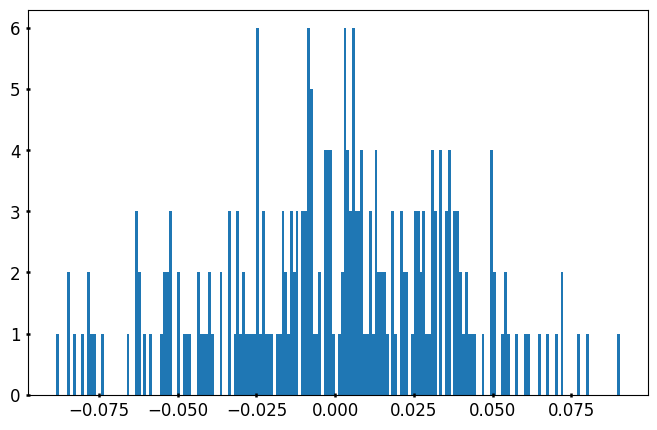

In [42]:
plt.hist(res['058531'][:,1] /(res['058531'][:,0]) - res['057980'][:,1]/res['057980'][:,0], bins= 200)

In [22]:
# Lets figure out whats wrong with my data 
second = {key: res[key][~res[key]['triggered']] for key in res.keys()}
second.keys()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

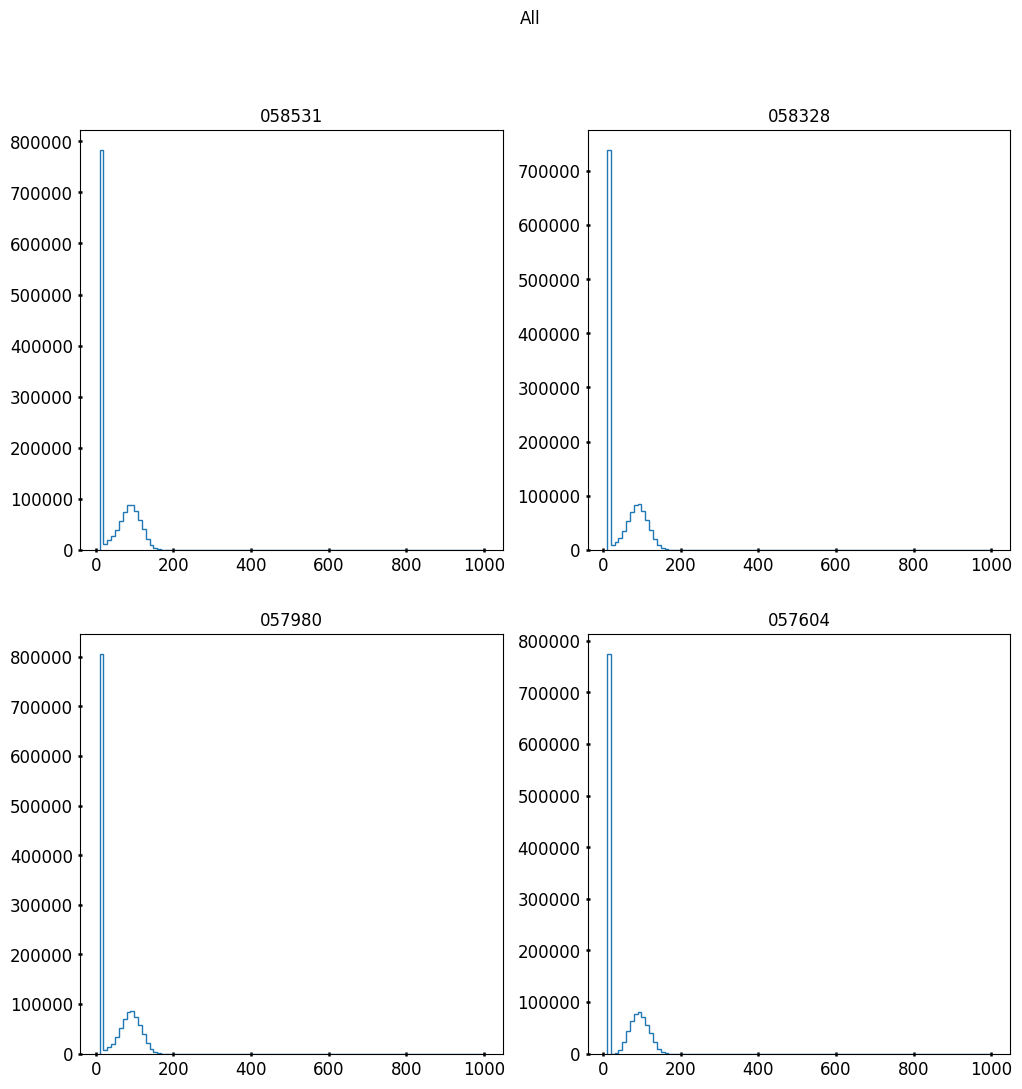

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax =ax.flatten()
fig.suptitle('All')
for i, key in enumerate(second.keys()):
    ax[i].hist(second[key]['amplitude_led'], bins=100, range=(10, 1000), histtype='step', label='SPE spectrum')
    ax[i].set_title(key)

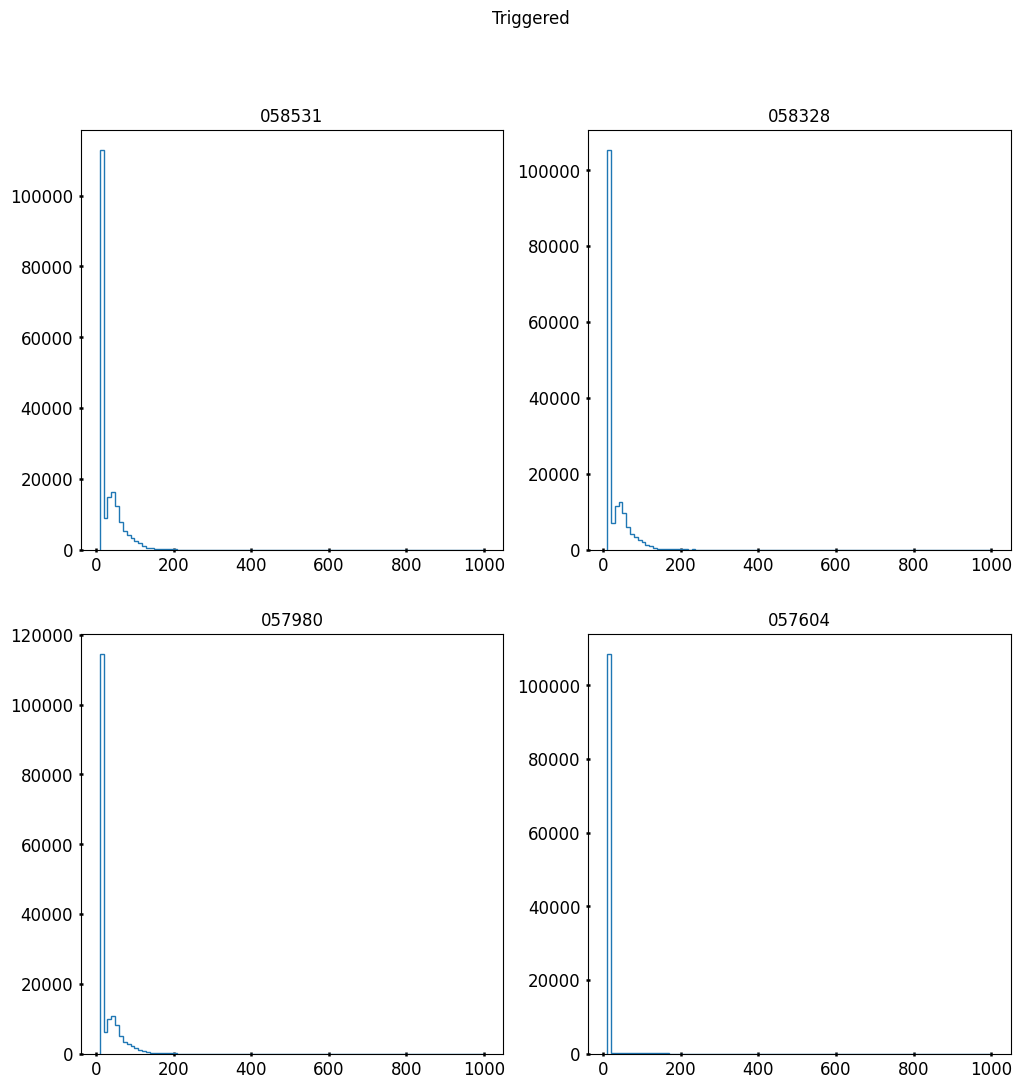

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax =ax.flatten()
fig.suptitle('Triggered')
for i, key in enumerate(second.keys()):
    ax[i].hist(second[key]['amplitude_led'], bins=100, range=(10, 1000), histtype='step', label='SPE spectrum')
    ax[i].set_title(key)

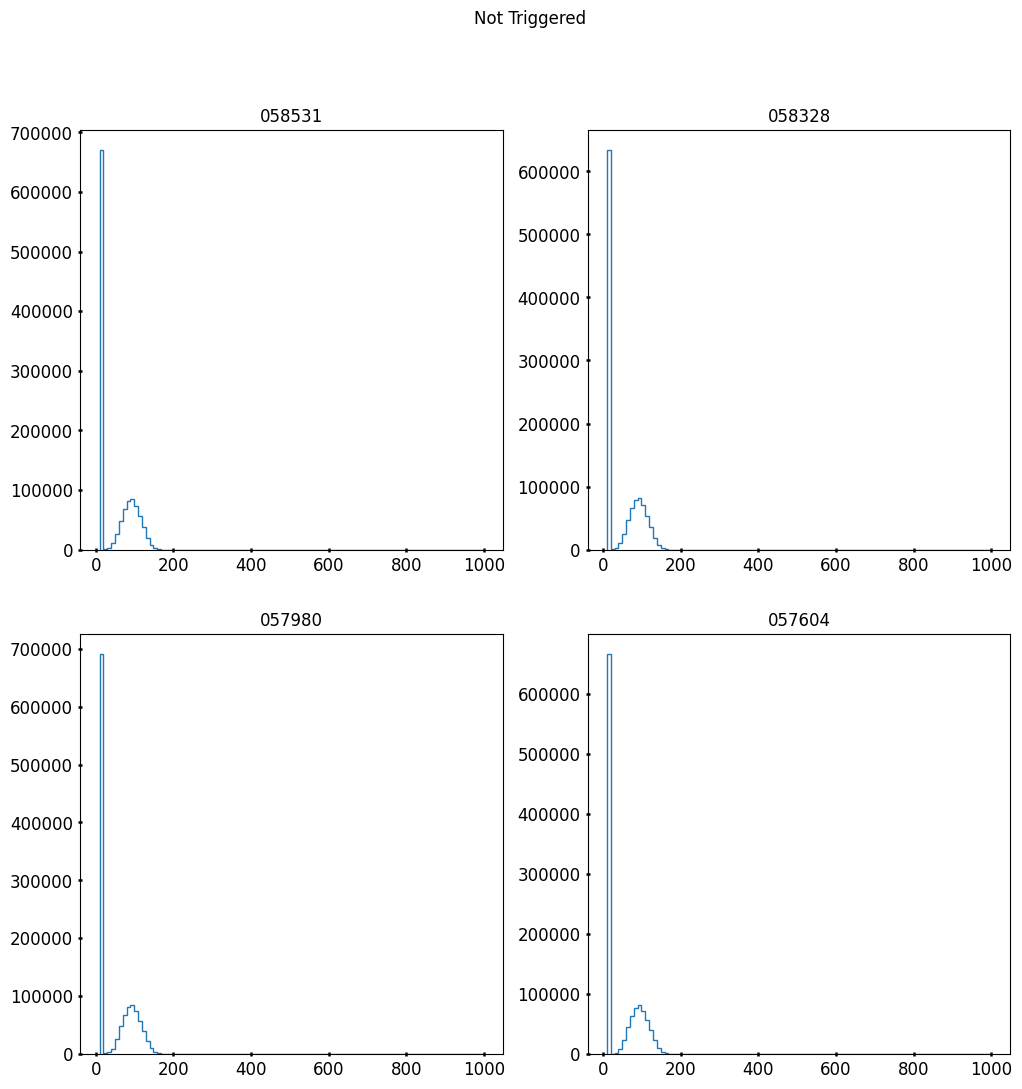

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax =ax.flatten()
fig.suptitle('Not Triggered')
for i, key in enumerate(second.keys()):
    ax[i].hist(second[key]['amplitude_led'], bins=100, range=(10, 1000), histtype='step', label='SPE spectrum')
    ax[i].set_title(key)

058531 92.01521 23.384834
058328 92.13452 23.288408
057980 93.02419 23.251705
057604 93.83561 23.011755


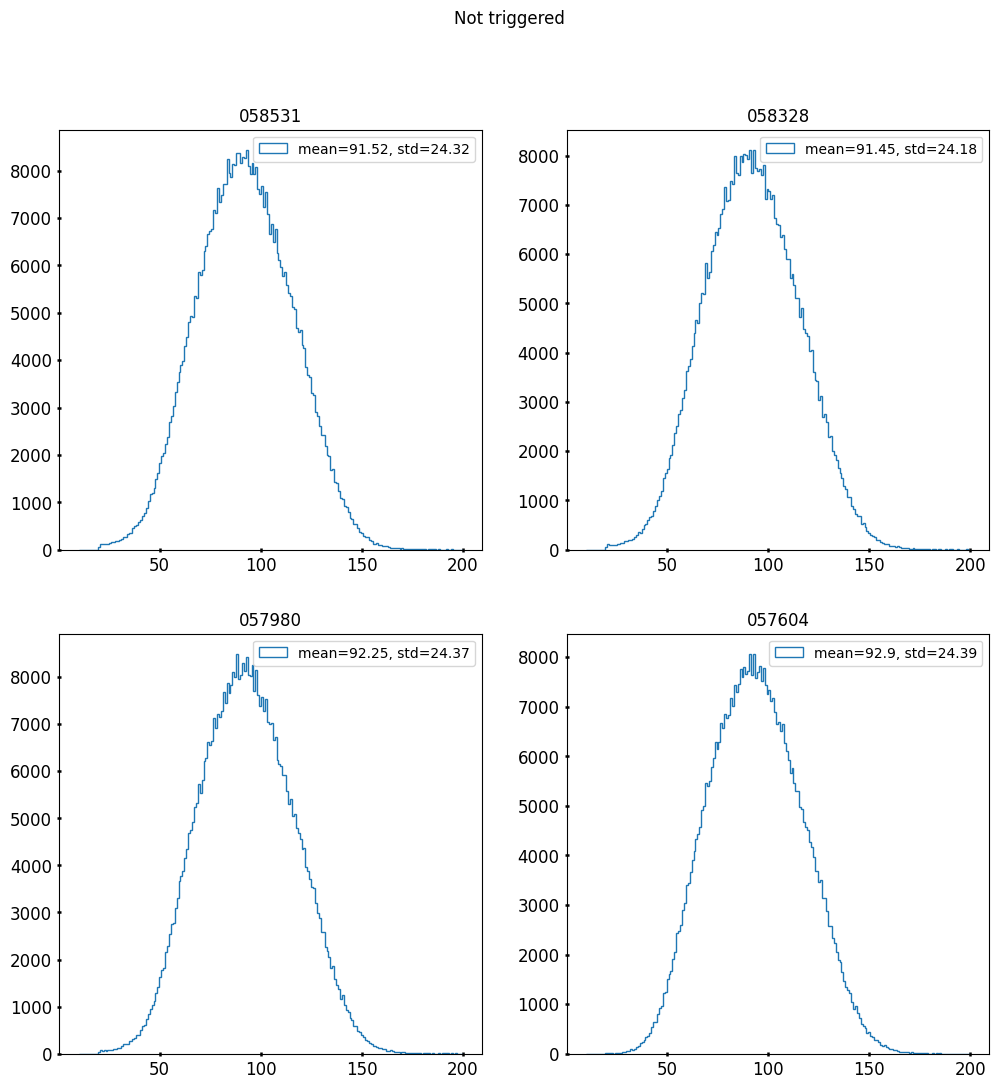

In [ ]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

full_set_statistic = {}
"""
Not triggered actually gives a far nicer (Gaussian Like) curve for most 
"""
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax =ax.flatten()
fig.suptitle('Not triggered')
bins =200
for i, key in enumerate(second.keys()):
    amplitudes = second[key]['amplitude_led'][(second[key]['amplitude_led'] > 20) & (second[key]['amplitude_led'] < 200)]
    counts, bin_edges = np.histogram(amplitudes, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
    popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), np.mean(amplitudes), np.std(amplitudes)])
    A, mu, sigma = popt
    ax[i].hist(amplitudes, bins=bins, range=(10, 200), histtype='step', label=f'mean={mu:.4}, std={sigma:.4}')
    print(key, np.mean(amplitudes), np.std(amplitudes))

    ax[i].set_title(key)
    ax[i].legend()
    full_set_statistic[key] = (mu, sigma)

In [ ]:
([full_set_statistic[i][1]/full_set_statistic[i][0] for i in full_set_statistic.keys()]), np.mean([full_set_statistic[i][1]/full_set_statistic[i][0] for i in full_set_statistic.keys()])

([np.float64(0.26577005905678247),
  np.float64(0.26443862382433514),
  np.float64(0.26417764921021497),
  np.float64(0.2625664996886468)],
 np.float64(0.26423820794499486))

# Conclusion

This doesnt work, the data is to unreliable and the variance appears to be too little between runs to warrant doing this seperately for each Krypton dataset 

So we have a global default of 0.264, lets quickly check the per PMT variance

/scratch/local/jobs/29293954/ipykernel_1872285/1011371639.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/scratch/local/jobs/29293954/ipykernel_1872285/1011371639.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/scratch/local/jobs/29293954/ipykernel_1872285/1011371639.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/scratch/local/jobs/29293954/ipykernel_1872285/1011371639.py:14: RuntimeWarning: Mean of empty slice.
  res[key][j,0] = chan_amplitude.mean()
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.11/site-packages/numpy/_core/_methods.py:13

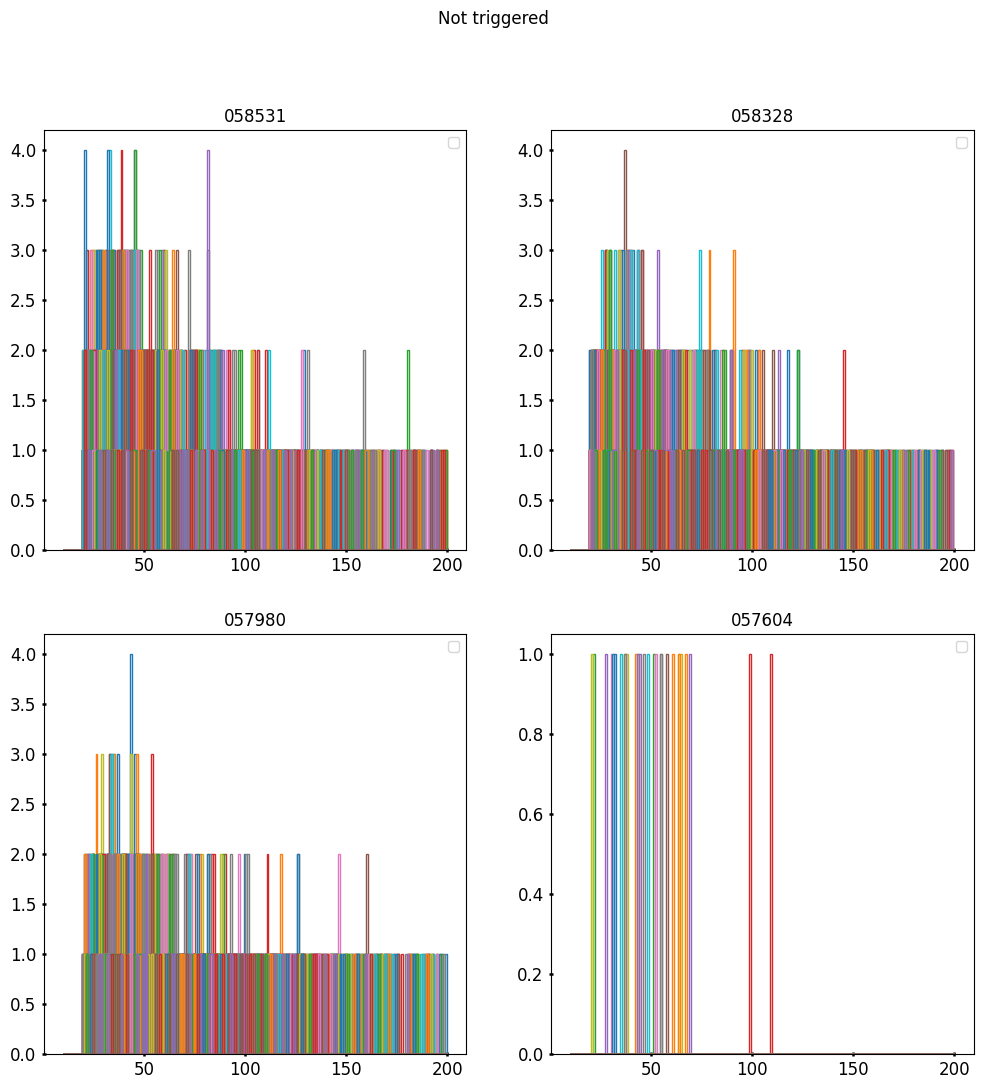

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax =ax.flatten()
fig.suptitle('Not triggered')
bins =200
not_dead_pmts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]

res ={}
for i, key in enumerate(second.keys()):
    res[key] = np.zeros((253,2))
    amplitudes = second[key]['amplitude_led']
    for j in not_dead_pmts:
        chan_amplitude = amplitudes[(second[key]['channel'] == j)]
        chan_amplitude = chan_amplitude[(chan_amplitude > 20) & (chan_amplitude < 200)]
        res[key][j,0] = chan_amplitude.mean()
        res[key][j,1] = chan_amplitude.std()
        ax[i].hist(chan_amplitude, bins=bins, range=(10, 200), histtype='step')

    ax[i].set_title(key)
    ax[i].legend()

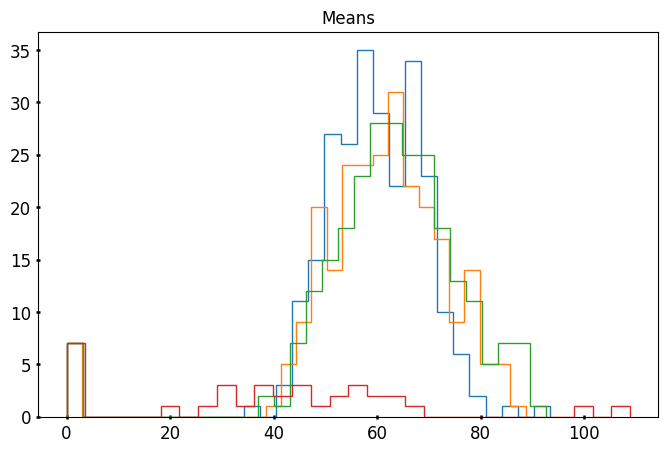

In [21]:
plt.title("Means")
for key in res.keys():
    plt.hist(res[key][:,0], bins=30, histtype='step', label='SPE spectrum')

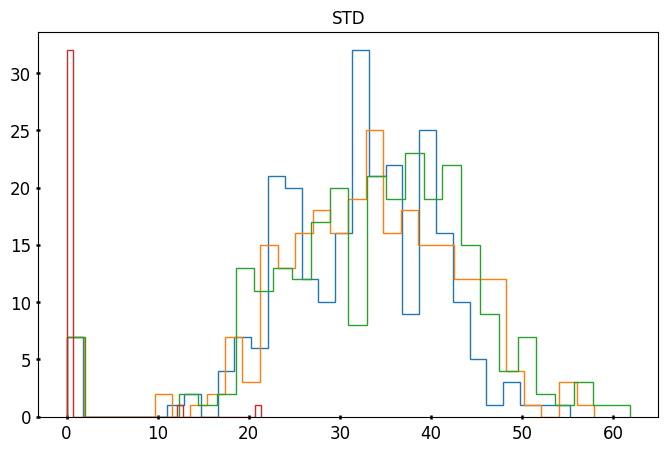

In [22]:
plt.title("STD")
for key in res.keys():
    plt.hist(res[key][:,1], bins=30, histtype='step', label='SPE spectrum')

0.5455944734375535
0.5378440134310641

0.5367354787376141
0.5401056770716449

0.5388460276364819
0.5414838831315021



/scratch/local/jobs/29293954/ipykernel_1872285/83751766.py:3: RuntimeWarning: invalid value encountered in divide
  mtp =res[key][:,1]/res[key][:,0]


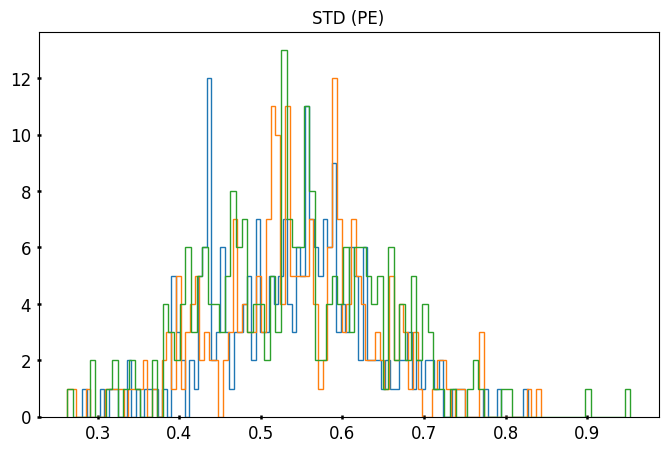

In [23]:
plt.title("STD (PE)")
for key in list(res.keys())[0:3]:
    mtp =res[key][:,1]/res[key][:,0]
    mtp = mtp[~np.isnan(mtp)]
    print(np.sort(mtp)[len(mtp)//2])    
    print(np.mean(mtp))    
    print()
    plt.hist(mtp[~np.isnan(mtp)], bins=100, histtype='step', label='SPE spectrum')

In [26]:
res.keys()

dict_keys(['058531', '058328', '057980', '057604'])

In [28]:
res2 = np.zeros((3, 253, 2))
res2[0,:,:] = res['058531']
res2[1,:,:] = res['058328']
res2[2,:,:] = res['057980']

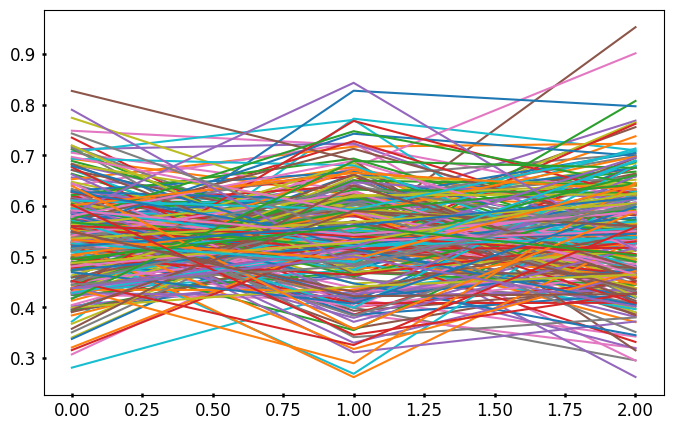

In [34]:
for i in not_dead_pmts:
    plt.plot([0,1,2], res2[:,i,1]/res2[:,i,0], label = i)

In [38]:
np.nanmean(np.abs((res2[0,:,0]/res2[0,:,1]) - (res2[1,:,0]/res2[1,:,1])))

/scratch/local/jobs/29293954/ipykernel_1872285/3228355550.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmean(np.abs((res2[0,:,0]/res2[0,:,1]) - (res2[1,:,0]/res2[1,:,1])))


np.float64(0.43997313134909577)